In [1]:
# reference: https://www.kaggle.com/kernels/notebooks/new?forkParentScriptVersionId=8421466&userName=fhiroki
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

/Users/hiroki/.pyenv/versions/3.5.1/lib/python3.5/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
new_transactions = pd.read_csv('input/original/small_new_transactions.csv',
                               index_col=0,
                               parse_dates=['purchase_date'])
historical_transactions = pd.read_csv('input/original/small_hist_transactions.csv',
                                      index_col=0,
                                      parse_dates=['purchase_date'])

def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

new_transactions = binarize(new_transactions)
historical_transactions = binarize(historical_transactions)

In [3]:
new_transactions.head()

authorized_flag          card_id  city_id  category_1  installments  \
0                1  C_ID_b3b9eae477       69           0             1   
1                1  C_ID_ab53c3b7b7      143           0             1   
2                1  C_ID_31839e7896       69           0             0   
3                1  C_ID_e5741986a9       69           0             0   
4                1  C_ID_ab5e006d01       69           0             1   

  category_3  merchant_category_id      merchant_id  month_lag  \
0          B                   434  M_ID_bf7836070a          2   
1          B                   683  M_ID_36a0bc4c75          1   
2          A                   683  M_ID_2637773dd2          2   
3          A                    80  M_ID_42d134923f          1   
4          B                   278  M_ID_697362ccad          2   

   purchase_amount       purchase_date  category_2  state_id  subsector_id  
0        -0.526920 2018-04-25 13:57:58         1.0         9            32  
1        -0.743151 2017-07-19 15:58:48         5.0         5            34  
2        -0.727584 2018-04-07 19:32:57         1.0         9            34  
3        -0.716855 2018-02-02 16:47:14         1.0         9            37  
4        -0.636944 2018-04-22 20:42:36         1.0         9            37

In [4]:
def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df

train = read_data('input/original/train.csv')
test = read_data('input/original/test.csv')

target = train['target']
del train['target']

In [5]:
train.head()

first_active_month          card_id  feature_1  feature_2  feature_3  \
0         2017-06-01  C_ID_92a2005557          5          2          1   
1         2017-01-01  C_ID_3d0044924f          4          1          0   
2         2016-08-01  C_ID_d639edf6cd          2          2          0   
3         2017-09-01  C_ID_186d6a6901          4          3          0   
4         2017-11-01  C_ID_cdbd2c0db2          1          3          0   

   elapsed_time  
0           245  
1           396  
2           549  
3           153  
4            92

In [ ]:
print(train.shape, test.shape)
print(new_transactions.shape, historical_transactions.shape)

In [ ]:
train.head()

In [ ]:
new_transactions.head()

In [ ]:
historical_transactions.head()

In [ ]:
historical_transactions['authorized_flag'].value_counts() / historical_transactions.shape[0] * 100

In [6]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
historical_transactions['month_diff'] = ((datetime.datetime.today() - historical_transactions['purchase_date']).dt.days)//30
historical_transactions['month_diff'] += historical_transactions['month_lag']

new_transactions['month_diff'] = ((datetime.datetime.today() - new_transactions['purchase_date']).dt.days)//30
new_transactions['month_diff'] += new_transactions['month_lag']

In [8]:
historical_transactions.head()

authorized_flag          card_id  city_id  category_1  installments  \
0                1  C_ID_5e54c0fb92      158           0             0   
1                1  C_ID_aa6b091251       -1           0             0   
2                1  C_ID_334ecb5825       -1           1             1   
3                1  C_ID_40b2f47218      143           0             1   
4                1  C_ID_38ad03cdcd      271           0             1   

  category_3  merchant_category_id      merchant_id  month_lag  \
0          A                   705  M_ID_c1a7024db1        -13   
1          A                   367  M_ID_bf5779026a         -5   
2          B                   661  M_ID_fc7d7969c3         -2   
3          B                   222  M_ID_5768173411         -6   
4          B                   307  M_ID_e36510761b         -4   

   purchase_amount       purchase_date  category_2  state_id  subsector_id  \
0        -0.726592 2017-01-12 15:34:29         1.0        15            33   
1        -0.668545 2017-09-15 13:40:24         NaN        -1            16   
2        -0.712497 2017-12-10 14:59:02         NaN        -1             8   
3        -0.718703 2017-08-01 13:38:13         5.0         5            21   
4        -0.701828 2017-10-30 00:00:00         1.0         9            19   

   month_diff  
0          12  
1          12  
2          12  
3          12  
4          11

In [9]:
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])

historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)

agg_fun = {'authorized_flag': ['mean']}
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]

Mem. usage decreased to 24.99 Mb (42.3% reduction)
Mem. usage decreased to 14.92 Mb (45.7% reduction)


In [52]:
auth_mean.head()

card_id  authorized_flag_mean
0  C_ID_00007093c1              0.000000
1  C_ID_000183fdda              1.000000
2  C_ID_00024e244b              1.000000
3  C_ID_0002ba3c2e              0.333333
4  C_ID_00032df08f              1.000000

In [10]:
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month

In [11]:
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
    'category_1': ['sum', 'mean'],
    'category_2_1.0': ['mean'],
    'category_2_2.0': ['mean'],
    'category_2_3.0': ['mean'],
    'category_2_4.0': ['mean'],
    'category_2_5.0': ['mean'],
    'category_3_A': ['mean'],
    'category_3_B': ['mean'],
    'category_3_C': ['mean'],
    'merchant_id': ['nunique'],
    'merchant_category_id': ['nunique'],
    'state_id': ['nunique'],
    'city_id': ['nunique'],
    'subsector_id': ['nunique'],
    'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
    'installments': ['sum', 'mean', 'max', 'min', 'std'],
    'purchase_month': ['mean', 'max', 'min', 'std'],
    'purchase_date': [np.ptp, 'min', 'max'],
    'month_lag': ['mean', 'max', 'min', 'std'],
    'month_diff': ['mean']
    }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [12]:
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history[:5]

card_id  hist_transactions_count  hist_city_id_nunique  \
0  C_ID_00007093c1                        1                     1   
1  C_ID_0002ba3c2e                        2                     1   
2  C_ID_00042d509c                        1                     1   
3  C_ID_000aa2220e                        1                     1   
4  C_ID_000b24f797                        1                     1   

   hist_month_lag_mean  hist_month_lag_max  hist_month_lag_min  \
0                 -4.0                  -4                  -4   
1                 -1.5                   0                  -3   
2                 -1.0                  -1                  -1   
3                 -3.0                  -3                  -3   
4                 -7.0                  -7                  -7   

   hist_month_lag_std  hist_installments_sum  hist_installments_mean  \
0                 NaN                      1                     1.0   
1             2.12132                      0                     0.0   
2                 NaN                      1                     1.0   
3                 NaN                      1                     1.0   
4                 NaN                      1                     1.0   

   hist_installments_max  hist_installments_min  hist_installments_std  \
0                      1                      1                    NaN   
1                      0                      0                    0.0   
2                      1                      1                    NaN   
3                      1                      1                    NaN   
4                      1                      1                    NaN   

   hist_category_2_4.0_mean  hist_purchase_month_mean  \
0                       0.0                      10.0   
1                       0.0                       8.5   
2                       0.0                      11.0   
3                       0.0                      11.0   
4                       0.0                       7.0   

   hist_purchase_month_max  hist_purchase_month_min  hist_purchase_month_std  \
0                       10                       10                      NaN   
1                       10                        7                  2.12132   
2                       11                       11                      NaN   
3                       11                       11                      NaN   
4                        7                        7                      NaN   

   hist_merchant_id_nunique  hist_merchant_category_id_nunique  \
0                         1                                  1   
1                         2                                  2   
2                         1                                  1   
3                         1                                  1   
4                         1                                  1   

   hist_purchase_amount_sum  hist_purchase_amount_mean  \
0                 -0.649414                  -0.649414   
1                 -1.103516                  -0.551758   
2                 -0.720703                  -0.720703   
3                 -0.044067                  -0.044067   
4                 -0.731934                  -0.731934   

   hist_purchase_amount_max  hist_purchase_amount_min  \
0                 -0.649414                 -0.649414   
1                 -0.506836                 -0.596680   
2                 -0.720703                 -0.720703   
3                 -0.044067                 -0.044067   
4                 -0.731934                 -0.731934   

   hist_purchase_amount_std  hist_month_diff_mean  hist_category_2_1.0_mean  \
0                       NaN                  12.0                       0.0   
1                  0.063538                  15.5                       0.0   
2                       NaN                  14.0                       0.0   
3                       NaN                  12.0                       1.0   
4            

In [13]:
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
authorized[:5]

card_id  auth_transactions_count  auth_city_id_nunique  \
0  C_ID_000183fdda                        1                     1   
1  C_ID_00024e244b                        1                     1   
2  C_ID_0002ba3c2e                        1                     1   
3  C_ID_00032df08f                        1                     1   
4  C_ID_0003be3c83                        3                     2   

   auth_month_lag_mean  auth_month_lag_max  auth_month_lag_min  \
0            -4.000000                  -4                  -4   
1            -5.000000                  -5                  -5   
2            -2.000000                  -2                  -2   
3             0.000000                   0                   0   
4            -3.666667                  -3                  -5   

   auth_month_lag_std  auth_installments_sum  auth_installments_mean  \
0                 NaN                      2                     2.0   
1                 NaN                      0                     0.0   
2                 NaN                      0                     0.0   
3                 NaN                      1                     1.0   
4            1.154701                      3                     1.0   

   auth_installments_max  auth_installments_min  auth_installments_std  \
0                      2                      2                    NaN   
1                      0                      0                    NaN   
2                      0                      0                    NaN   
3                      1                      1                    NaN   
4                      1                      1                    0.0   

   auth_category_2_4.0_mean  auth_purchase_month_mean  \
0                       0.0                 10.000000   
1                       0.0                  9.000000   
2                       0.0                  8.000000   
3                       0.0                 11.000000   
4                       0.0                 10.333333   

   auth_purchase_month_max  auth_purchase_month_min  auth_purchase_month_std  \
0                       10                       10                      NaN   
1                        9                        9                      NaN   
2                        8                        8                      NaN   
3                       11                       11                      NaN   
4                       11                        9                 1.154701   

   auth_merchant_id_nunique  auth_merchant_category_id_nunique  \
0                         1                                  1   
1                         1                                  1   
2                         1                                  1   
3                         1                                  1   
4                         3                                  3   

   auth_purchase_amount_sum  auth_purchase_amount_mean  \
0                 -0.612305                  -0.612305   
1                 -0.734863                  -0.734863   
2                 -0.705566                  -0.705566   
3                 -0.664551                  -0.664551   
4                 -2.074219                  -0.691406   

   auth_purchase_amount_max  auth_purchase_amount_min  \
0                 -0.612305                 -0.612305   
1                 -0.734863                 -0.734863   
2                 -0.705566                 -0.705566   
3                 -0.664551                 -0.664551   
4                 -0.626465                 -0.727539   

   auth_purchase_amount_std  auth_month_diff_mean  auth_category_2_1.0_mean  \
0                       NaN             12.000000                  0.000000   
1                       NaN             12.000000                  0.000000   
2                       NaN             16.000000                  1.000000   
3                       NaN             15.000000                  1.000000   
4            

In [14]:
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new[:5]

card_id  new_transactions_count  new_city_id_nunique  \
0  C_ID_0001238066                       1                    1   
1  C_ID_0001506ef0                       1                    1   
2  C_ID_0001793786                       4                    3   
3  C_ID_000183fdda                       1                    1   
4  C_ID_0003be3c83                       1                    1   

   new_month_lag_mean  new_month_lag_max  new_month_lag_min  \
0                1.00                  1                  1   
1                1.00                  1                  1   
2                1.25                  2                  1   
3                2.00                  2                  2   
4                2.00                  2                  2   

   new_month_lag_std  new_installments_sum  new_installments_mean  \
0                NaN                    -1                   -1.0   
1                NaN                     0                    0.0   
2                0.5                     0                    0.0   
3                NaN                    -1                   -1.0   
4                NaN                     1                    1.0   

   new_installments_max  new_installments_min  new_installments_std  \
0                    -1                    -1                   NaN   
1                     0                     0                   NaN   
2                     0                     0                   0.0   
3                    -1                    -1                   NaN   
4                     1                     1                   NaN   

   new_category_2_4.0_mean  new_purchase_month_mean  new_purchase_month_max  \
0                      0.0                     3.00                       3   
1                      0.0                     3.00                       3   
2                      0.0                    11.25                      12   
3                      0.0                     4.00                       4   
4                      0.0                     4.00                       4   

   new_purchase_month_min  new_purchase_month_std  new_merchant_id_nunique  \
0                       3                     NaN                        1   
1                       3                     NaN                        1   
2                      11                     0.5                        4   
3                       4                     NaN                        1   
4                       4                     NaN                        1   

   new_merchant_category_id_nunique  new_purchase_amount_sum  \
0                                 1                -0.151978   
1                                 1                -0.731934   
2                                 3                 0.973633   
3                                 1                -0.107666   
4                                 1                -0.717773   

   new_purchase_amount_mean  new_purchase_amount_max  new_purchase_amount_min  \
0                 -0.151978                -0.151978                -0.151978   
1                 -0.731934                -0.731934                -0.731934   
2                  0.243408                 1.506836                -0.592285   
3                 -0.107666                -0.107666                -0.107666   
4                 -0.717773                -0.717773                -0.717773   

   new_purchase_amount_std  new_month_diff_mean  new_category_2_1.0_mean  \
0                      NaN                12.00                     1.00   
1                      NaN                12.00                     0.00   
2                 0.900391                15.75                     0.25   
3                      NaN                11.00                     0.00   
4                      NaN                12.00                     1.00   

   new_category_2_2.0_mean  new_category_3_A_mean  new_state_id_nunique  \
0                      0.0             

In [15]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group
#___________________________________________________________
final_group =  aggregate_per_month(authorized_transactions) 
final_group[:10]

card_id  month_lag_mean  month_lag_std  installments_count_mean  \
0  C_ID_000183fdda            -4.0            NaN                      1.0   
1  C_ID_00024e244b            -5.0            NaN                      1.0   
2  C_ID_0002ba3c2e            -2.0            NaN                      1.0   
3  C_ID_00032df08f             0.0            NaN                      1.0   
4  C_ID_0003be3c83            -4.0       1.414214                      1.5   
5  C_ID_0004725b87            -5.0            NaN                      1.0   
6  C_ID_0004888ddd            -5.0            NaN                      1.0   
7  C_ID_0005f16cc8            -8.0       5.656854                      1.0   
8  C_ID_0006152db8             0.0            NaN                      1.0   
9  C_ID_000664aa02            -1.0            NaN                      1.0   

   installments_count_std  installments_sum_mean  installments_sum_std  \
0                     NaN                    2.0                   NaN   
1                     NaN                    0.0                   NaN   
2                     NaN                    0.0                   NaN   
3                     NaN                    1.0                   NaN   
4                0.707107                    1.5              0.707107   
5                     NaN                    1.0                   NaN   
6                     NaN                    0.0                   NaN   
7                0.000000                    0.0              0.000000   
8                     NaN                    0.0                   NaN   
9                     NaN                    0.0                   NaN   

   installments_mean_mean  installments_mean_std  installments_min_mean  \
0                     2.0                    NaN                    2.0   
1                     0.0                    NaN                    0.0   
2                     0.0                    NaN                    0.0   
3                     1.0                    NaN                    1.0   
4                     1.0                    0.0                    1.0   
5                     1.0                    NaN                    1.0   
6                     0.0                    NaN                    0.0   
7                     0.0                    0.0                    0.0   
8                     0.0                    NaN                    0.0   
9                     0.0                    NaN                    0.0   

   installments_min_std  installments_max_mean  installments_max_std  \
0                   NaN                    2.0                   NaN   
1                   NaN                    0.0                   NaN   
2                   NaN                    0.0                   NaN   
3                   NaN                    1.0                   NaN   
4                   0.0                    1.0                   0.0   
5                   NaN                    1.0                   NaN   
6                   NaN                    0.0                   NaN   
7                   0.0                    0.0                   0.0   
8                   NaN                    0.0                   NaN   
9                   NaN                    0.0                   NaN   

   installments_std_mean  installments_std_std  purchase_amount_count_mean  \
0                    NaN                   NaN                         1.0   
1                    NaN                   NaN                         1.0   
2                    NaN                   NaN                         1.0   
3                    NaN                   NaN                         1.0   
4                    0.0                   NaN                         1.5   
5                    NaN                   NaN                         1.0   
6                    NaN                   NaN                         1.0   
7                    NaN                   NaN                         1.0   
8               

In [16]:
def successive_aggregates(df, field1, field2):
    t = df.groupby(['card_id', field1])[field2].mean()
    u = pd.DataFrame(t).reset_index().groupby('card_id')[field2].agg(['mean', 'min', 'max', 'std'])
    u.columns = [field1 + '_' + field2 + '_' + col for col in u.columns.values]
    u.reset_index(inplace=True)
    return u

In [17]:
additional_fields = successive_aggregates(new_transactions, 'category_1', 'purchase_amount')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'installments', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'city_id', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'category_1', 'installments'),
                                            on = 'card_id', how='left')

In [18]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

train = pd.merge(train, additional_fields, on='card_id', how='left')
test = pd.merge(test, additional_fields, on='card_id', how='left')

In [19]:
print(train.shape, test.shape)

(201917, 163) (123623, 163)


In [51]:
train.head()

first_active_month          card_id  feature_1  feature_2  feature_3  \
0         2017-06-01  C_ID_92a2005557          5          2          1   
1         2017-01-01  C_ID_3d0044924f          4          1          0   
2         2016-08-01  C_ID_d639edf6cd          2          2          0   
3         2017-09-01  C_ID_186d6a6901          4          3          0   
4         2017-11-01  C_ID_cdbd2c0db2          1          3          0   

   elapsed_time  hist_transactions_count  hist_city_id_nunique  \
0           245                      NaN                   NaN   
1           396                      NaN                   NaN   
2           549                      NaN                   NaN   
3           153                      NaN                   NaN   
4            92                      NaN                   NaN   

   hist_month_lag_mean  hist_month_lag_max  hist_month_lag_min  \
0                  NaN                 NaN                 NaN   
1                  NaN                 NaN                 NaN   
2                  NaN                 NaN                 NaN   
3                  NaN                 NaN                 NaN   
4                  NaN                 NaN                 NaN   

   hist_month_lag_std  hist_installments_sum  hist_installments_mean  \
0                 NaN                    NaN                     NaN   
1                 NaN                    NaN                     NaN   
2                 NaN                    NaN                     NaN   
3                 NaN                    NaN                     NaN   
4                 NaN                    NaN                     NaN   

   hist_installments_max  hist_installments_min  hist_installments_std  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   

   hist_category_2_4.0_mean  hist_purchase_month_mean  \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3                       NaN                       NaN   
4                       NaN                       NaN   

   hist_purchase_month_max  hist_purchase_month_min  hist_purchase_month_std  \
0                      NaN                      NaN                      NaN   
1                      NaN                      NaN                      NaN   
2                      NaN                      NaN                      NaN   
3                      NaN                      NaN                      NaN   
4                      NaN                      NaN                      NaN   

   hist_merchant_id_nunique  hist_merchant_category_id_nunique  \
0                       NaN                                NaN   
1                       NaN                                NaN   
2                       NaN                                NaN   
3                       NaN                                NaN   
4                       NaN                                NaN   

   hist_purchase_amount_sum  hist_purchase_amount_mean  \
0                       NaN                        NaN   
1                       NaN                        NaN   
2                       NaN                        NaN   
3                       NaN                        NaN   
4                       NaN                        NaN   

   hist_purchase_amount_max  hist_purchase_amount_min  \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3                       NaN                       NaN   
4                       NaN   

In [48]:
target.describe()

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64

In [44]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
#          'max_depth': 9,
         'max_depth': 7,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [41]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = ['feature_2', 'feature_3']

In [45]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.80075	valid_1's rmse: 3.84754
[200]	training's rmse: 3.77983	valid_1's rmse: 3.83171
[300]	training's rmse: 3.76726	valid_1's rmse: 3.82382
[400]	training's rmse: 3.75902	valid_1's rmse: 3.82002
[500]	training's rmse: 3.75329	valid_1's rmse: 3.81801
[600]	training's rmse: 3.74892	valid_1's rmse: 3.81691
[700]	training's rmse: 3.7458	valid_1's rmse: 3.81617
[800]	training's rmse: 3.74308	valid_1's rmse: 3.81552
[900]	training's rmse: 3.74089	valid_1's rmse: 3.81518
[1000]	training's rmse: 3.73891	valid_1's rmse: 3.81508
[1100]	training's rmse: 3.73688	valid_1's rmse: 3.8149
[1200]	training's rmse: 3.73496	valid_1's rmse: 3.8147
[1300]	training's rmse: 3.73303	valid_1's rmse: 3.81464
[1400]	training's rmse: 3.7311	valid_1's rmse: 3.81464
[1500]	training's rmse: 3.72928	valid_1's rmse: 3.8146
Early stopping, best iteration is:
[1325]	training's rmse: 3.73245	valid_1's rmse: 3.81455
fold n°1
Tr

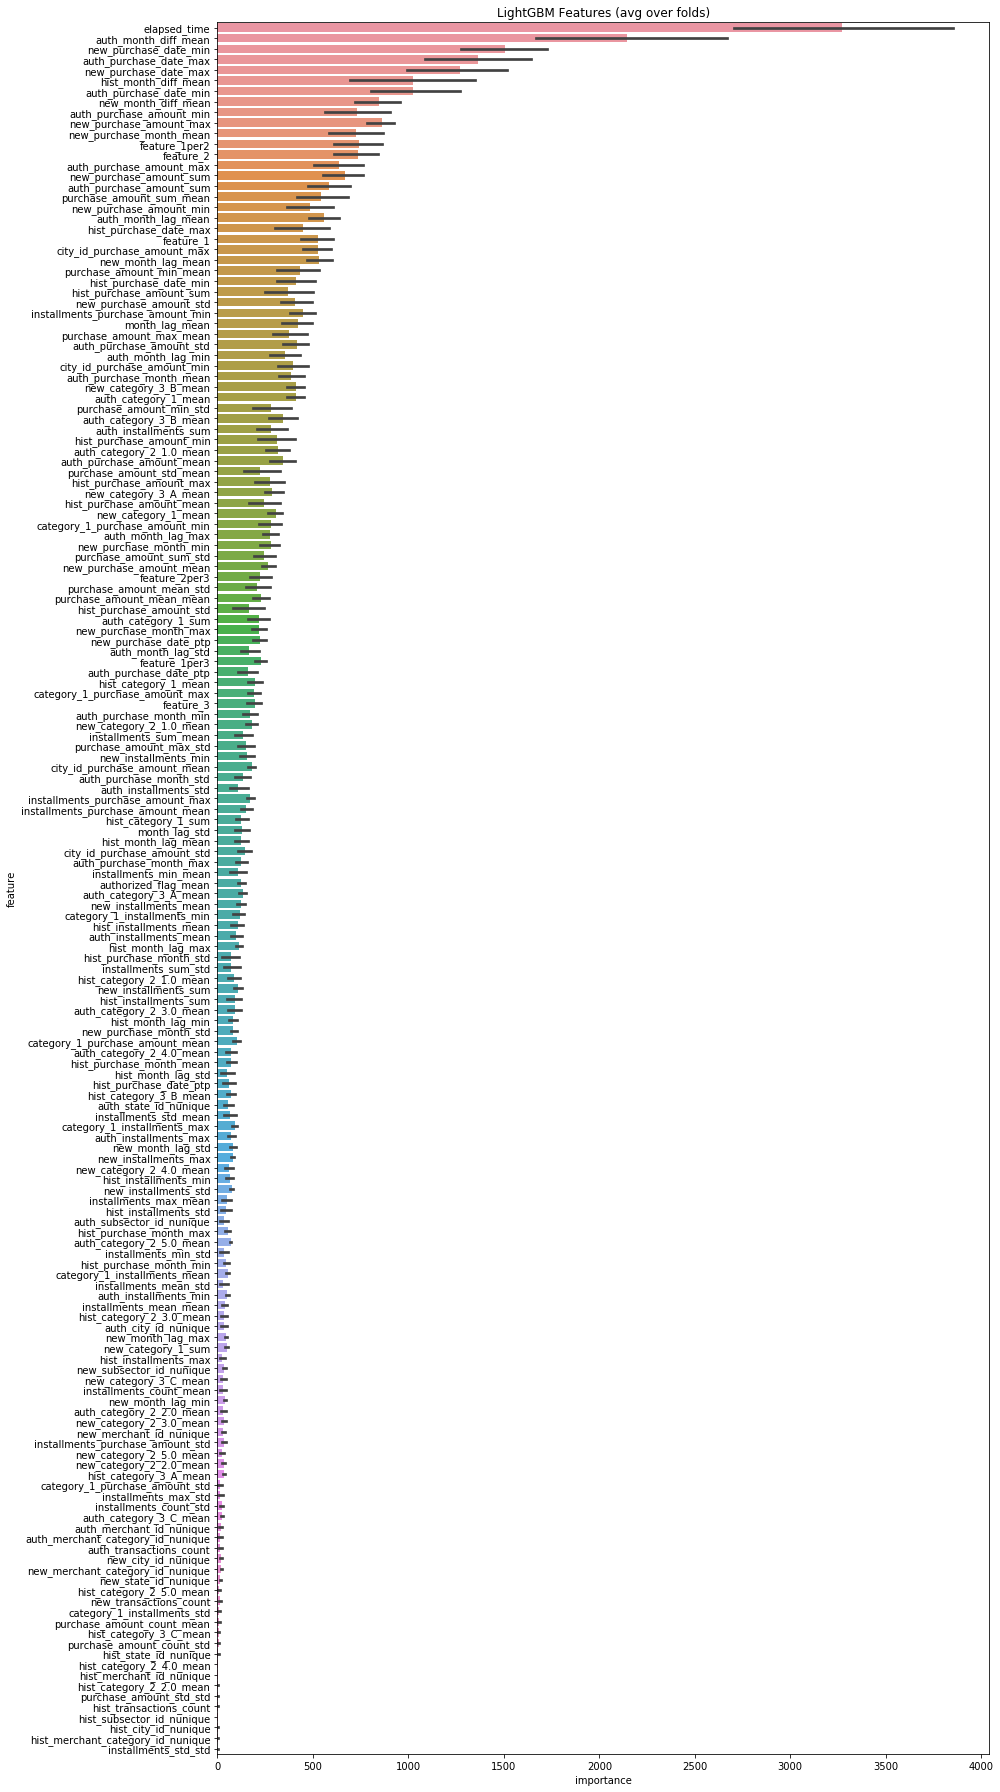

In [46]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

In [31]:
feature_importance_df.head()

feature  importance  fold
0                feature_1        1293     1
1                feature_2        1524     1
2                feature_3         517     1
3             elapsed_time        5164     1
4  hist_transactions_count           0     1

In [30]:
fold_importance_df.head()

feature  importance  fold
0                feature_1         896     5
1                feature_2         894     5
2                feature_3         312     5
3             elapsed_time        3127     5
4  hist_transactions_count           1     5

In [35]:
features = feature_importance_df[:100]['feature']

In [36]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.79801	valid_1's rmse: 3.84659
[200]	training's rmse: 3.77496	valid_1's rmse: 3.83032
[300]	training's rmse: 3.7617	valid_1's rmse: 3.8233
[400]	training's rmse: 3.75245	valid_1's rmse: 3.82006
[500]	training's rmse: 3.74578	valid_1's rmse: 3.81843
[600]	training's rmse: 3.74073	valid_1's rmse: 3.81767
[700]	training's rmse: 3.73692	valid_1's rmse: 3.81708
[800]	training's rmse: 3.73365	valid_1's rmse: 3.81669
[900]	training's rmse: 3.73082	valid_1's rmse: 3.81669
[1000]	training's rmse: 3.7282	valid_1's rmse: 3.81683
Early stopping, best iteration is:
[878]	training's rmse: 3.73138	valid_1's rmse: 3.81658
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.81616	valid_1's rmse: 3.77088
[200]	training's rmse: 3.79254	valid_1's rmse: 3.75617
[300]	training's rmse: 3.77877	valid_1's rmse: 3.74994
[400]	training's rmse: 3.76929	valid_1's rmse: 3.7471